### CITS4404 Practical Project

# Camo Worms!

<div style="margin-left: 0px">
    &nbsp;
    <img src="velvet-worms.jpg" width=600>
    <br>
    <br>
</div>

Australian _velvet worms_ come in many colours, possibly as a camouflage function ([Current Biology](https://www.cell.com/current-biology/comments/S0960-9822(11)00208-9)).

In [1]:
# Imports

import numpy as np
import imageio.v3 as iio

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.bezier as mbezier
from sklearn.metrics.pairwise import euclidean_distances

import cv2
from shapely.geometry import LineString
import time

rng = np.random.default_rng()
Path = mpath.Path
mpl.rcParams['figure.dpi']= 72 #size of images


In [2]:
# Global variables

IMAGE_DIR = 'images'
IMAGE_NAME='original'
MASK = [320, 560, 160, 880] # ymin ymax xmin xmax

Image name (shape) (intensity max, min, mean, std)

original (240, 720) (210, 0, 49.3, 34.8)


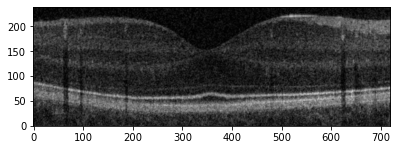

In [3]:
# Read, crop and display image and stats
def crop (image, mask):
    h, w = np.shape(image)
    return image[max(mask[0],0):min(mask[1],h), max(mask[2],0):min(mask[3],w)]

def prep_image (imdir, imname, mask):
    print("Image name (shape) (intensity max, min, mean, std)\n")
    image = np.flipud(crop(iio.imread(imdir+'/'+imname+".png"), mask))
    print("{} {} ({}, {}, {}, {})".format(imname, np.shape(image), np.max(image), np.min(image), round(np.mean(image),1), round(np.std(image),1)))
    plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower') # use vmin and vmax to stop imshow from scaling
    plt.show()
    return image

image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)

In [4]:
import time

start_time = time.time()
function_times = {}

def measure_time(f):
    def timed(*args, **kw):
        ts = time.time()
        result = f(*args, **kw)
        te = time.time()
        function_time = te - ts
        
        if f.__name__ not in function_times:
            function_times[f.__name__] = [0, 0]  # [total_time, call_count]
        function_times[f.__name__][0] += function_time
        function_times[f.__name__][1] += 1
        
        return result
    
    return timed

def print_function_times():
    end_time = time.time()
    total_program_time = end_time - start_time
    
    print()
    print("### PROFILING ###")
    print("Total program time: {:.2f} sec".format(total_program_time))
    print("Function times:")
    for function_name, (total_time, call_count) in function_times.items():
        percentage = (total_time / total_program_time) * 100
        average_time = total_time / call_count
        print("- {}: {:.2f} sec ({:.2f}%), {} calls".format(
            function_name, total_time, percentage, call_count, average_time))
    print()

In [52]:
class Camo_Worm:
    def __init__(self, x, y, r, theta, deviation_r, deviation_gamma, width, colour):
        self.x = x
        self.y = y
        self.r = r
        self.theta = theta
        self.dr = deviation_r
        self.dgamma = deviation_gamma
        self.width = width
        self.colour = colour
        p0 = [self.x - self.r * np.cos(self.theta), self.y - self.r * np.sin(self.theta)]
        p2 = [self.x + self.r * np.cos(self.theta), self.y + self.r * np.sin(self.theta)]
        p1 = [self.x + self.dr * np.cos(self.theta+self.dgamma), self.y + self.dr * np.sin(self.theta+self.dgamma)]
        self.bezier = mbezier.BezierSegment(np.array([p0, p1,p2]))

    def control_points (self):
        return self.bezier.control_points

    def path (self):
        return mpath.Path(self.control_points(), [Path.MOVETO, Path.CURVE3, Path.CURVE3])

    def patch (self):
        return mpatches.PathPatch(self.path(), fc='None', ec=str(self.colour), lw=self.width, capstyle='round')

    def intermediate_points (self, intervals=None):
        if intervals is None:
            intervals = max(3, int(np.ceil(self.r/8)))
        return self.bezier.point_at_t(np.linspace(0,1,intervals))

    def approx_length (self):
        intermediates = intermediate_points(self)
        eds = euclidean_distances(intermediates,intermediates)
        return np.sum(np.diag(eds,1))

    def bezier_tangent(self, t):
        P0, P1, P2 = self.control_points()
        return 2 * (1 - t) * (P1 - P0) + 2 * t * (P2 - P1)
    
    @measure_time
    def colour_at_t(self, t, image):
        intermediates = np.int64(np.round(np.array(self.bezier.point_at_t(t)).reshape(-1,2)))
        height, width = image.shape[:2]
        intermediates[:, 0] = np.clip(intermediates[:, 0], 0, width - 1)
        intermediates[:, 1] = np.clip(intermediates[:, 1], 0, height - 1)
        colours = [image[point[1],point[0]] for point in intermediates] #? had to swap point[1] and point[0] cause y and x were in the other order
        return(np.array(colours)/255)
    
    @measure_time
    def img_colour_at_w(self, image, t_values=[0, 0.5, 1]):
        width_points = []
        for t in t_values:
            # Calculate the point on the bezier curve
            base_point = self.bezier.point_at_t(t)
            # Calculate the tangent at this point
            tangent = self.bezier_tangent(t)
            # Normalize the tangent vector
            tangent_norm = tangent / np.linalg.norm(tangent)
            # Calculate the normal (perpendicular) to the tangent
            normal = np.array([-tangent_norm[1], tangent_norm[0]])
            # Calculate points across the width of the worm
            half_width = self.width 
            if t in [0, 1]:  # Only at the tips
                # Points perpendicular to the path
                points_at_t = [
                    base_point + normal * half_width * i
                    for i in [-1, 1]  # Left and right side of the worm
                ]
                # Points tangent to the path
                if t == 0:
                    points_tangent = [
                        base_point + tangent_norm * half_width * -1 # Backward along the tangent
                    ]
                else:
                    points_tangent = [
                        base_point + tangent_norm * half_width * 1 # forward along the tangent
                    ]
                width_points.extend(points_at_t)
                width_points.extend(points_tangent)
            else:
                # Middle points, just the normal ones
                points_at_t = [
                    base_point + normal * half_width * i
                    for i in [-1, 1]  # Left and right side
                ]
                width_points.extend(points_at_t)
        intermediates = np.int64(np.round(np.array(width_points)))
        try:
            return np.array(image[intermediates[:, 1], intermediates[:, 0]]) / 255.0
        except:
            return np.array([0 for _ in range(len(t_values))])

    @measure_time
    def img_color_across_t(self, t, image):
        # average image colour across all points in t 
        intermediates = np.int64(np.round(np.array(self.bezier.point_at_t(t)).reshape(-1,2)))
        try:
            return np.array(image[intermediates[:, 1], intermediates[:, 0]]) / 255.0
        except:
            return np.array([0 for _ in range(len(t))])

In [6]:
class Drawing:
    def __init__ (self, image):
        self.fig, self.ax = plt.subplots()
        self.image = image
        self.im = self.ax.imshow(self.image, cmap='gray', origin='lower')

    def add_patches(self, patches):
        try:
            for patch in patches:
                self.ax.add_patch(patch)
        except TypeError:
            self.ax.add_patch(patches)

    def add_dots(self, points, radius=4, **kwargs):
        try:
            for point in points:
                self.ax.add_patch(mpatches.Circle((point[0],point[1]), radius, **kwargs))
        except TypeError:
            self.ax.add_patch(mpatches.Circle((points[0],points[1]), radius, **kwargs))

    def add_worms(self, worms, alpha=1.0, colour=None):
        colourmap = mpl.colormaps["rainbow"]
        try:
            for worm in worms:
                patch = worm.patch()
                patch.set_alpha(alpha)
                if colour != None:
                    patch.set_edgecolor(colourmap(colour))
                self.ax.add_patch(patch)
        except TypeError:
            patch = worms.patch()
            patch.set_alpha(alpha)
            if colour != None:
                patch.set_edgecolor(colourmap(colour))
            self.ax.add_patch(patch)

    def show(self, save=None):
        if save is not None:
            plt.savefig(save)
        plt.show()


In [7]:
# Example of a random worm. You may do this differently.

    # centre points, angles and colour chosen from uniform distributions
    # lengths chosen from normal distributions with two std parameters passed
    # width chosen from gamma distribution with shape parameter 3 and scale passed

def random_worm (imshape, init_params):
    (radius_std, deviation_std, width_theta) = init_params
    (ylim, xlim) = imshape
    midx = xlim * rng.random()
    midy = ylim * rng.random()
    r = radius_std * np.abs(rng.standard_normal())
    theta = rng.random() * np.pi
    dr = deviation_std * np.abs(rng.standard_normal())
    dgamma = rng.random() * np.pi
    colour = rng.random()
    width = width_theta * rng.standard_gamma(3)
    return Camo_Worm(midx, midy, r, theta, dr, dgamma, width, colour)


In [8]:
# Initialise a random clew
def initialise_clew (size, imshape, init_params):
    clew = []
    for i in range(size):
        clew.append(random_worm(imshape, init_params))
    return clew

In [62]:
class Fitness:
    def __init__(self, image, swarms):
        self.image = image
        self.swarms = swarms
        self.times = {}
        
    @measure_time
    def get(self, worm):
        img_height, img_width = self.image.shape[:2]
        # colour factor
        @measure_time
        def colour():
            DIVISIONS = 8
            # points along centre path 
            t = np.linspace(0,1,DIVISIONS)
            path_colour = worm.img_color_across_t(t, self.image)
            width_colour = worm.img_colour_at_w(self.image)
            ps = 1 - np.mean(np.abs(worm.colour - path_colour))
            ws = 1 - np.mean(np.abs(worm.colour - width_colour))
            # subtract from 1 since higher fitness is better
            return (int(ps+ws), 4)

        @measure_time
        # width factor
        def width():
            # example weakly encouraging width to be 8
            return (1 / max(abs(worm.width - 5),1),5) 

        @measure_time
        # length factor
        def length():
            # provides benefit up to a value of img_width/8 then no more benefit
            if worm.r < 5:
                return (0,0)
            return (1,1)

        @measure_time
        # discourage from going out of bounds
        def outside():
            min_x, min_y = np.min(worm.control_points(), axis=0)
            max_x, max_y = np.max(worm.control_points(), axis=0)
            if min_x < 0 or max_x >= img_width or min_y < 0 or max_y >= img_height:
                return (-1, 10)  # high cost for going outside
            else:
                return (0, 0) # doesn't affect worm if it's inside boundaries

        @measure_time
        # distance between swarms
        def g_distance():
            closest_worm = None
            min_distance = float('inf')  # Initialize with a large number
            avgs = []
            # Iterate through each swarm and each worm within the swarm
            for s in swarms:
                if s in swarms[::len(swarms)//10]:
                    avgs.append(s.population[0])
                if worm not in s.population:  # Ensure not checking the worm's own swarm
                    other_worm = s.population[0]
                    # Calculate Euclidean distance
                    distance = ((worm.x - other_worm.x) ** 2 + (worm.y - other_worm.y) ** 2) ** 0.5
                    if distance < min_distance:
                        min_distance = distance
                        closest_worm = other_worm  # Update the closest worm
            # Apply upper limit to distance based on image dimensions and number of swarms
            distance_limit = min(min_distance, min(img_width, img_height) * 2 / np.ceil(len(swarms) ** 0.5))
            # Normalize the distance
            normalized_distance = distance_limit / (min(img_width, img_height) / np.ceil(len(swarms) ** 0.5))
            return (normalized_distance, 1.2, closest_worm, avgs)
    
        # detect if the worm is crossing another, penalise heavily
        @measure_time
        def g_cross_factor(avgs):
            line1 = LineString(worm.path().vertices)
            for other_worm in avgs:
                line2 = LineString(other_worm.path().vertices)
                # Check if the lines intersect and that the intersection is not just touching
                if line1.intersects(line2) and not line1.touches(line2):
                    return (-1,5)
            return (0,0)

        # detect if the worm is roughly parallel with its closest friend
        @measure_time
        def g_parallelism(closest_worm):
            r1 = worm.theta
            r2 = closest_worm.theta
            angle_diff = np.abs(r1 - r2)
            angle_diff = min(angle_diff, 2*np.pi - angle_diff)  # This accounts for wrapping around the circle
            # Normalize the difference to a score from 0 to 1
            # Maximum difference that affects parallelism is pi (180 degrees)
            similarity_score = 1 - (angle_diff / np.pi)  # Normalize the difference by pi
            return (similarity_score,0.15)

        # each factor is a tuple of (fitness, multiplier)
        g_distance = g_distance()
        g_cross_factor = g_cross_factor(g_distance[3])
        g_parallelism = g_parallelism(g_distance[2])
        factors = [outside(), length(), width(), colour(), g_distance, g_cross_factor, g_parallelism]
        return sum([x[0] * x[1] for x in factors])

In [10]:
import random, copy
"""
Each Swarm represents a single worm 
"""
class Swarm:
    def __init__ (self, image, population):
        self.image = image
        self.population = population
        self.fitness = None # must be updated after Fitness class is created
        
        # CONSTANTS #
        
        # number of individuals in the selection tournament
        # a higher tnm_k means it will select more of the best, and less of the worst
        # may converge faster without as much exploration
        self.tnm_k = 3
        
        # rate of mutation which should be between 0 and 1
        # a high rate may prevent convergence, a low rate will need more iterations to converge
        self.m_rate = 0.01 
        
    @measure_time
    def update(self):
        assert(self.fitness != None)
        fitnesses = [fitness.get(x) for x in self.population]
        new_population = []
        size = len(self.population)
        for i in range(size):
            # tournament selection
            selected_ix = random.randint(0,size-1)
            for ix in [random.randint(0,size-1) for x in range(self.tnm_k-1)]:
                if fitnesses[ix] > fitnesses[selected_ix]:
                    selected_ix = ix
            parent = self.population[selected_ix]
            # mutating
            height, width = image.shape[:2]
            c_x = min(max(parent.x + random.uniform(-self.m_rate*width/2,self.m_rate*width/2),0),width)
            c_y = min(max(parent.y + random.uniform(-self.m_rate*height/2,self.m_rate*height/2),0),height)
            max_r = max(width,height)/2
            c_r = min(max(parent.r + random.uniform(-self.m_rate*max_r/2,self.m_rate*max_r/2),0),max_r)
            c_colour = min(max(parent.colour + random.uniform(-self.m_rate/2,self.m_rate/2),0),1)
            c_theta = (parent.theta + random.uniform(-self.m_rate*np.pi,self.m_rate*np.pi)) % (np.pi*2)
            c_dr = min(max(parent.dr + random.uniform(-self.m_rate*c_r,self.m_rate*c_r),-c_r),c_r)
            c_dgamma = min(max(parent.dgamma + random.uniform(-self.m_rate*np.pi,self.m_rate*np.pi),-np.pi),np.pi)
            c_width = min(max(parent.width + random.uniform(-self.m_rate*c_r,self.m_rate*c_r),1),2*c_r)
            # child
            child = Camo_Worm(c_x, c_y, c_r, c_theta, c_dr, c_dgamma, c_width, c_colour)
            new_population.append(child)
        self.population = new_population
    @measure_time
    def avg_worm(self):
        avg = copy.deepcopy(self.population[0])
        for field in ['x', 'y', 'r', 'theta', 'dr', 'dgamma', 'width']:
            setattr(avg, field, np.mean([getattr(w, field) for w in self.population]))
        return avg
    

C:\Users\calsp\AppData\Local\Temp\ipykernel_35700\2238234594.py:57: RuntimeWarning: invalid value encountered in divide
  tangent_norm = tangent / np.linalg.norm(tangent)
C:\Users\calsp\AppData\Local\Temp\ipykernel_35700\2238234594.py:86: RuntimeWarning: invalid value encountered in cast
  intermediates = np.int64(np.round(np.array(width_points)))


Iteration: 1
Time Remaining: 977 seconds
Fitness: [7.78, 3.75, 3.85, 2.77, 8.0, 8.66, 5.45, 7.68, 7.86, 4.49, 2.48, 5.84, 4.46, 3.06, 6.75, 7.48, 6.29, 5.2, 8.18, 4.22, 4.89, 6.4, 8.48, 2.78, 5.01, 3.69, 6.85, 4.45, 4.83, 7.15, 3.44, 5.83, 8.6, 5.82, 5.95, 7.49, 6.87, 5.87, 1.05, 5.01, 5.55, 7.82, 8.17, 5.59, 6.58, 5.65, 4.09, 7.06, 6.7, 1.62, 7.12, 6.26, 7.04, 4.87, 7.67, 5.5, 6.53, 4.81, 6.24, 5.77, 4.95, 5.63, 5.03, 7.57, 6.7, 3.58, 3.17, 7.94, 4.87, 5.22, 5.61, 5.28, 5.86, 4.16, 2.79, 5.46, 7.21, 4.4, 4.22, 3.56, 5.93, 6.25, 7.56, 5.79, 4.55, 6.48, 5.98, 3.5, 8.86, 7.06, 5.01, 7.95, 5.18, 7.38, 4.94, 4.77, 7.06, 4.06, 5.92, 7.22, 6.99, 6.2, 4.71, 6.77, 5.98, 3.17, 6.34, 2.9, 8.31, 5.32, 6.4, 7.1, 4.6, 5.22, 6.93, 7.03, 7.27, 4.69, 7.61, 3.65, 5.34, 5.46, 4.69, 5.29, 4.04, 5.96, 6.15, 7.89, 4.8, 5.48, 4.38, 9.05, 4.58, 4.37, 2.83, 6.52, 4.55, 3.06, 8.02, 6.23, 5.32, 2.8, 5.16, 3.79, 6.05, 5.05, 6.48, 2.29, 5.72, 7.96, 3.12, 5.53, 5.17, 5.21, 6.47, 2.88, 7.03, 7.94, 7.35, 4.35, 5.78,

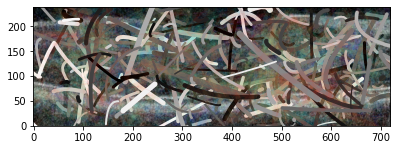


Iteration: 20
Time Remaining: 505 seconds
Fitness: [4.98, 7.88, 8.04, 8.58, 8.4, 9.47, 9.29, 8.4, 5.72, 10.2, 8.71, 9.61, 9.41, 5.32, 9.52, 7.47, 5.99, 8.35, 8.67, 9.6, 8.81, 9.03, 8.04, 7.64, 8.73, 9.8, 9.34, 8.7, 9.76, 9.06, 3.95, 8.36, 9.94, 9.07, 6.02, 7.53, 8.97, 8.75, 3.68, 9.84, 9.74, 9.5, 9.54, 5.38, 8.59, 9.55, 7.8, 7.41, 9.18, 9.04, 8.34, 8.68, 6.66, 9.01, 9.77, 10.3, 10.2, 3.99, 8.55, 9.11, 8.08, 9.09, 9.97, 7.57, 9.64, 6.25, 9.28, 7.02, 10.0, 7.39, 8.01, 9.58, 10.6, 9.07, 9.21, 9.7, 9.19, 9.7, 7.37, 8.18, 7.44, 7.66, 1.83, 8.65, 4.23, 4.17, 8.9, 9.43, 9.88, 8.48, 5.91, 7.37, 9.19, 9.9, 8.87, 7.75, 6.98, 7.61, 4.13, 9.62, 7.21, 8.47, 9.58, 8.27, 5.68, 6.66, 7.74, 8.95, 9.13, 8.56, 8.56, 7.19, 8.25, 8.2, 7.59, 9.68, 9.0, 8.73, 6.41, 8.7, 5.86, 6.02, 9.0, 3.51, 8.5, 9.35, 8.47, 8.45, 9.55, 9.15, 9.1, 8.71, 9.16, 8.14, 8.43, 7.34, 8.08, 7.79, 10.5, 9.01, 9.67, 7.27, 9.08, 8.19, 9.47, 9.74, 9.54, 8.8, 9.52, 9.32, 7.89, 9.19, 8.9, 8.59, 9.36, 7.33, 9.05, 8.77, 10.4, 5.61, 10.2, 

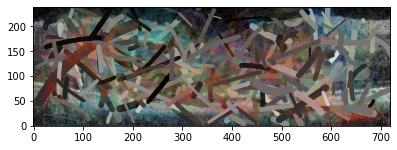


Iteration: 40
Time Remaining: 442 seconds
Fitness: [8.2, 10.1, 11.1, 10.4, 10.1, 9.94, 8.45, 9.8, 4.6, 9.66, 10.8, 9.34, 10.2, 9.91, 9.89, 8.41, 10.0, 9.74, 10.2, 9.91, 6.76, 8.0, 9.09, 10.2, 10.0, 10.6, 10.2, 8.75, 9.79, 9.43, 6.29, 10.6, 10.3, 9.98, 9.85, 6.33, 9.25, 8.3, 10.6, 9.17, 9.56, 9.88, 3.76, 10.2, 10.0, 10.4, 9.75, 9.68, 8.37, 9.99, 7.65, 9.83, 8.6, 10.2, 11.1, 10.8, 10.9, 6.47, 10.9, 9.79, 7.45, 10.4, 10.0, 9.15, 9.46, 5.05, 10.5, 11.3, 9.19, 10.4, 10.2, 10.6, 9.73, 10.0, 9.96, 10.5, 8.41, 9.59, 10.1, 10.3, 9.27, 9.71, 7.67, 10.5, 9.98, 9.56, 10.4, 7.2, 10.5, 10.1, 4.44, 9.6, 9.83, 10.4, 9.78, 9.08, 10.1, 10.4, 10.6, 9.34, 6.69, 10.6, 10.9, 10.3, 10.5, 10.7, 8.07, 7.8, 10.7, 9.92, 9.66, 9.89, 10.1, 7.12, 10.3, 10.0, 10.5, 10.2, 10.5, 9.82, 11.4, 10.5, 7.05, 10.5, 9.5, 10.2, 7.82, 7.99, 7.08, 8.51, 9.92, 10.6, 10.2, 10.1, 10.3, 7.03, 7.45, 9.57, 9.08, 9.61, 10.5, 8.88, 8.05, 9.99, 8.97, 9.66, 10.9, 10.5, 9.67, 11.3, 8.27, 10.9, 9.83, 8.42, 10.1, 10.4, 7.53, 9.58, 8.92, 9.4

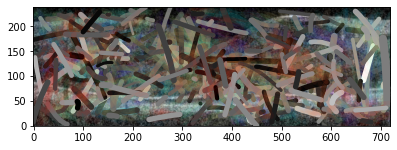


Iteration: 60
Time Remaining: 387 seconds
Fitness: [7.83, 10.5, 10.8, 10.2, 10.3, 11.3, 11.5, 9.71, 10.8, 9.5, 9.64, 10.3, 9.92, 10.7, 9.82, 10.4, 10.8, 8.47, 10.6, 10.7, 9.13, 10.5, 9.29, 10.7, 11.0, 10.5, 10.1, 10.9, 5.71, 10.7, 10.6, 12.0, 11.0, 8.37, 10.0, 6.68, 8.23, 10.5, 10.3, 10.6, 10.8, 10.8, 9.68, 11.2, 10.5, 9.62, 9.85, 11.1, 10.9, 9.65, 10.9, 11.3, 10.5, 9.86, 10.5, 11.0, 10.2, 5.83, 10.9, 11.2, 8.07, 10.7, 10.2, 10.8, 10.3, 5.44, 10.6, 10.5, 10.5, 10.9, 10.7, 11.7, 11.8, 10.9, 11.2, 11.3, 9.43, 10.7, 11.2, 10.5, 10.5, 11.3, 11.4, 10.9, 11.5, 10.1, 9.74, 10.4, 10.6, 10.4, 10.3, 10.4, 10.4, 10.8, 11.3, 9.98, 9.98, 10.8, 10.2, 9.36, 9.54, 10.0, 10.1, 7.96, 11.4, 10.7, 11.0, 6.22, 10.5, 11.7, 8.92, 11.1, 10.2, 9.82, 9.5, 11.1, 11.1, 11.3, 9.38, 8.88, 8.9, 9.25, 10.6, 10.4, 10.9, 10.2, 10.3, 11.1, 4.24, 9.61, 10.8, 9.67, 10.4, 11.0, 11.2, 10.9, 8.73, 11.4, 9.98, 11.1, 10.6, 8.87, 10.2, 9.1, 10.4, 4.43, 9.68, 10.4, 11.8, 10.6, 7.48, 10.7, 9.88, 8.83, 9.94, 9.87, 9.94, 9.73, 9.3

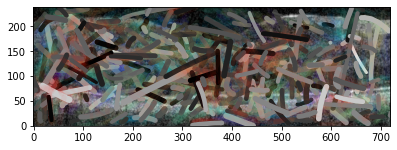


Iteration: 80
Time Remaining: 333 seconds
Fitness: [9.31, 11.0, 11.0, 11.2, 11.1, 10.8, 11.2, 11.1, 11.1, 10.8, 11.2, 9.8, 9.16, 11.3, 10.6, 12.5, 8.51, 11.1, 9.97, 10.8, 11.3, 7.87, 10.7, 10.4, 10.9, 10.1, 11.1, 11.6, 8.51, 11.4, 8.91, 11.2, 10.4, 8.68, 10.7, 5.89, 10.7, 10.8, 11.9, 11.5, 11.5, 11.4, 11.2, 10.4, 8.86, 10.5, 11.0, 10.9, 8.84, 10.8, 9.38, 11.3, 10.6, 10.6, 10.8, 10.7, 11.4, 6.16, 10.8, 8.56, 11.1, 10.6, 11.8, 11.0, 11.4, 6.72, 8.96, 10.4, 8.99, 10.7, 9.63, 11.2, 10.9, 10.3, 10.9, 10.6, 10.3, 10.9, 10.5, 11.0, 11.9, 10.6, 8.16, 10.0, 11.5, 11.2, 10.9, 10.1, 9.57, 11.5, 10.5, 10.4, 10.6, 10.9, 11.2, 10.8, 10.6, 10.6, 11.3, 9.96, 10.6, 10.7, 11.9, 10.4, 11.4, 11.0, 9.69, 11.7, 10.6, 11.4, 10.5, 11.0, 10.8, 11.2, 10.2, 10.5, 10.1, 11.6, 10.3, 10.1, 9.32, 11.8, 10.1, 11.4, 10.8, 10.8, 9.67, 8.1, 9.85, 10.8, 10.3, 9.39, 11.2, 11.0, 12.0, 11.3, 12.3, 10.8, 10.2, 11.6, 11.3, 10.5, 10.8, 10.7, 11.5, 7.19, 11.1, 10.6, 11.4, 11.4, 9.51, 11.1, 10.9, 10.6, 10.6, 10.7, 11.2, 11.1, 1

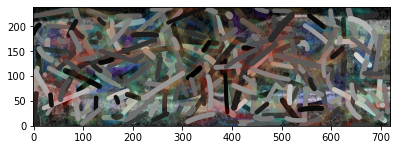


Iteration: 100
Time Remaining: 277 seconds
Fitness: [11.4, 10.8, 10.5, 11.4, 10.7, 11.7, 12.1, 10.7, 11.2, 11.5, 10.7, 10.9, 10.4, 11.2, 10.9, 11.7, 10.2, 10.6, 11.8, 10.9, 11.3, 8.7, 11.5, 9.62, 11.5, 11.4, 11.0, 11.3, 12.0, 10.9, 10.3, 11.9, 9.32, 11.3, 11.2, 8.13, 9.43, 10.8, 11.9, 11.3, 11.2, 10.3, 11.3, 11.2, 11.8, 11.4, 11.1, 11.2, 9.5, 10.9, 9.18, 11.4, 11.9, 10.9, 10.8, 10.6, 11.3, 7.14, 10.7, 11.4, 9.29, 11.4, 10.9, 11.3, 11.0, 8.11, 11.5, 12.2, 11.6, 11.4, 10.4, 10.7, 10.9, 11.6, 11.6, 11.7, 10.9, 11.4, 10.9, 11.7, 11.8, 11.6, 11.1, 11.7, 11.8, 11.6, 11.2, 10.2, 11.0, 11.5, 9.52, 6.44, 10.8, 10.5, 9.97, 11.1, 10.3, 11.1, 10.7, 10.9, 10.8, 10.8, 10.1, 11.4, 11.1, 10.7, 11.1, 11.4, 11.0, 11.8, 11.1, 11.1, 11.7, 11.2, 12.0, 11.2, 11.0, 11.7, 10.7, 10.6, 8.73, 11.4, 11.3, 9.15, 11.2, 10.6, 11.4, 12.0, 12.2, 11.0, 10.6, 11.2, 11.2, 11.5, 11.1, 11.0, 9.75, 11.3, 11.4, 10.7, 11.2, 11.7, 11.1, 10.5, 8.92, 11.3, 11.7, 11.2, 11.1, 11.2, 10.7, 9.82, 9.03, 6.31, 11.2, 10.7, 11.0, 11.0, 

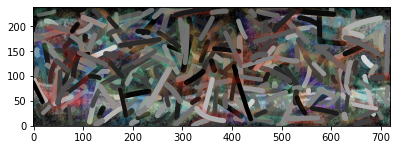


Iteration: 120
Time Remaining: 222 seconds
Fitness: [11.6, 11.3, 11.7, 11.7, 11.7, 11.8, 11.8, 11.6, 11.8, 11.3, 11.3, 11.6, 11.5, 11.7, 11.9, 12.0, 11.5, 11.7, 11.4, 11.5, 12.2, 10.8, 11.9, 11.8, 12.0, 11.7, 11.6, 11.5, 11.4, 11.7, 9.47, 9.74, 11.7, 11.4, 11.3, 10.6, 10.6, 11.0, 11.6, 11.6, 11.1, 11.9, 12.4, 12.1, 11.9, 11.7, 11.6, 11.4, 11.3, 11.3, 11.8, 11.7, 11.9, 11.4, 11.7, 11.2, 11.5, 7.36, 12.0, 11.2, 11.5, 11.6, 11.3, 11.4, 11.0, 8.26, 11.9, 12.1, 11.1, 11.5, 11.5, 11.7, 11.6, 11.0, 11.5, 12.2, 10.8, 11.6, 11.3, 12.0, 11.9, 12.0, 12.5, 8.36, 11.3, 11.6, 10.9, 11.6, 11.0, 11.6, 11.1, 10.6, 11.5, 11.8, 11.4, 12.1, 11.7, 11.8, 11.7, 12.0, 12.2, 11.8, 11.7, 11.4, 11.8, 11.7, 11.2, 10.8, 11.5, 12.0, 11.7, 11.9, 11.1, 11.3, 10.8, 11.3, 11.6, 8.95, 11.3, 11.3, 9.17, 11.3, 8.51, 10.3, 10.3, 11.9, 11.1, 10.1, 9.22, 12.1, 11.2, 11.3, 11.6, 11.8, 12.2, 12.1, 11.0, 12.1, 11.7, 11.6, 12.0, 12.1, 11.4, 11.6, 11.0, 12.4, 12.0, 10.8, 11.2, 12.2, 10.8, 11.6, 11.8, 11.2, 11.3, 11.7, 11.6, 11.4

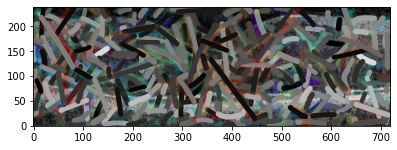


Iteration: 140
Time Remaining: 167 seconds
Fitness: [8.69, 11.7, 11.4, 11.8, 11.2, 11.9, 12.1, 12.0, 12.0, 11.9, 11.9, 11.9, 10.9, 11.8, 12.0, 12.4, 12.1, 11.3, 11.9, 11.4, 11.9, 11.7, 12.2, 11.1, 11.5, 12.0, 11.9, 11.9, 11.6, 12.3, 9.88, 11.7, 9.53, 11.5, 11.7, 9.74, 9.3, 11.7, 12.2, 11.4, 11.6, 9.15, 11.9, 12.1, 11.9, 12.1, 11.7, 12.0, 11.3, 11.9, 12.0, 11.8, 12.3, 12.0, 11.8, 11.8, 11.8, 7.68, 11.9, 11.6, 10.8, 12.0, 11.7, 11.6, 11.5, 8.47, 8.96, 11.9, 12.2, 12.0, 10.8, 11.6, 11.8, 11.9, 11.6, 11.7, 10.8, 11.8, 12.3, 11.9, 12.3, 12.0, 10.8, 11.3, 11.7, 11.9, 12.1, 12.0, 11.5, 11.9, 10.7, 9.12, 11.6, 12.1, 12.1, 11.3, 7.13, 12.0, 11.8, 12.4, 11.7, 11.7, 12.0, 11.9, 11.4, 12.1, 11.9, 10.2, 11.4, 12.5, 11.4, 11.9, 12.0, 11.6, 11.8, 11.8, 11.8, 11.1, 11.5, 11.6, 7.43, 12.4, 7.88, 12.2, 11.3, 11.5, 12.0, 12.1, 7.95, 12.0, 11.6, 11.7, 11.5, 12.3, 7.92, 12.0, 9.38, 12.0, 11.9, 11.8, 12.2, 9.42, 11.8, 12.1, 11.3, 10.3, 11.7, 11.8, 11.9, 12.4, 11.0, 11.8, 11.9, 10.2, 11.8, 11.9, 12.0, 11.6,

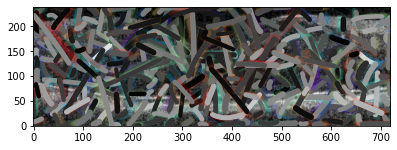


Iteration: 160
Time Remaining: 111 seconds
Fitness: [11.1, 11.7, 12.1, 11.7, 12.1, 11.9, 12.2, 12.0, 11.9, 11.8, 11.9, 11.9, 12.0, 11.9, 12.0, 12.4, 11.8, 11.9, 11.9, 11.7, 12.2, 12.0, 12.3, 12.0, 9.73, 12.3, 12.0, 12.4, 12.1, 12.1, 10.9, 6.66, 12.1, 12.0, 11.8, 12.5, 6.81, 12.0, 11.9, 11.9, 11.9, 10.3, 12.1, 12.5, 11.9, 12.1, 11.9, 12.0, 11.8, 12.4, 11.9, 11.9, 12.5, 12.0, 11.7, 12.1, 11.8, 8.14, 11.9, 11.9, 9.59, 12.3, 11.7, 11.9, 11.8, 8.23, 8.94, 12.4, 7.2, 12.4, 11.1, 12.1, 12.0, 12.3, 12.0, 12.0, 11.9, 12.0, 12.4, 12.4, 12.1, 12.0, 12.5, 11.8, 12.0, 12.1, 11.9, 12.0, 12.2, 11.9, 11.7, 6.9, 11.9, 12.2, 12.1, 12.0, 11.7, 12.1, 11.8, 12.2, 12.0, 11.9, 12.1, 12.1, 12.2, 12.0, 12.2, 12.4, 11.8, 12.4, 12.3, 12.0, 11.9, 11.9, 12.3, 11.6, 12.0, 12.0, 11.8, 11.9, 9.26, 12.4, 7.18, 7.77, 7.41, 12.1, 12.1, 12.3, 7.03, 12.1, 11.7, 11.7, 11.9, 10.3, 10.9, 12.4, 6.92, 12.2, 12.2, 11.5, 12.1, 8.26, 12.0, 12.3, 12.1, 10.2, 11.2, 11.9, 11.1, 12.3, 9.05, 12.0, 12.2, 9.48, 12.0, 12.4, 11.7, 12.0, 

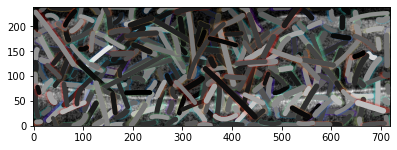


Iteration: 180
Time Remaining: 55 seconds
Fitness: [9.89, 11.9, 12.1, 12.0, 12.1, 12.1, 12.3, 12.1, 12.1, 12.2, 11.9, 12.0, 12.1, 12.1, 12.0, 9.35, 11.8, 12.0, 12.0, 12.1, 12.2, 12.1, 12.4, 10.9, 7.49, 12.1, 12.2, 12.5, 11.9, 12.1, 10.5, 7.38, 11.1, 12.1, 12.3, 12.5, 8.29, 12.0, 12.1, 11.8, 12.1, 11.4, 12.1, 10.5, 12.0, 12.0, 12.0, 12.4, 10.5, 12.2, 12.1, 12.2, 12.4, 12.1, 11.9, 12.4, 12.0, 8.03, 11.9, 12.2, 11.0, 12.2, 11.9, 11.9, 11.9, 8.32, 7.11, 12.5, 10.5, 12.2, 10.2, 12.1, 12.0, 12.4, 12.2, 12.1, 11.8, 12.1, 12.3, 12.1, 12.4, 12.1, 10.3, 12.1, 12.3, 12.1, 12.0, 12.2, 12.0, 12.1, 10.3, 7.01, 12.2, 12.2, 12.1, 12.4, 11.1, 12.1, 12.0, 12.3, 11.9, 12.2, 11.1, 12.1, 12.3, 10.4, 12.1, 12.3, 11.9, 12.4, 12.3, 12.2, 12.1, 12.0, 12.3, 12.1, 11.9, 9.42, 11.8, 12.0, 7.4, 12.3, 7.15, 12.4, 8.24, 11.9, 12.1, 12.3, 11.3, 12.3, 12.1, 12.0, 12.1, 10.4, 11.3, 12.2, 10.2, 12.4, 12.2, 12.2, 12.2, 12.2, 12.0, 12.3, 11.1, 11.2, 10.2, 12.1, 6.19, 12.4, 11.4, 12.4, 12.1, 11.4, 11.9, 12.2, 11.9, 11.7, 

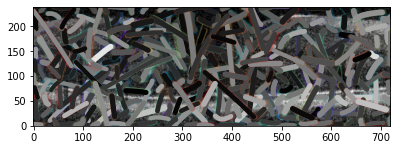

In [63]:
# for profiling
start_time = time.time()
function_times = {}
profiling = True # change to True to see function times
# constants
iterations = 200
swarm_size = 10
num_swarms = 300
swarms = [Swarm(image, initialise_clew(swarm_size, image.shape, (40, 30, 1))) for _ in range(num_swarms)]
fitness = Fitness(image, swarms)
for s in swarms:
    s.fitness = fitness
    #s.tnm_k = 4
    #s.m_rate = 0.02

for it in range(iterations):
    fitnesses = []
    for swarm in swarms:
        # start the mutation rate high for a short time then keep it low for a long time (exponential)
        # allows for fast exploration at the start with fine tuning of the final solution at the end
        swarm.m_rate = 0.1 * np.exp(-3 * (it / iterations)) # -3 growth rate so it quickly decreases
        # same principle with tournament size, except that it starts low and increases over time
        # if tournament size = population, all children will come from the best parent (no diversity)
        swarm.tnm_k = max(int(len(swarm.population) / (1+np.exp(-5 * (it/iterations-0.8)))+1), 2) 
        swarm.update()
    if (it+1) % (iterations//10) == 0 or int(it) == 0:
        all_fitnesses = [sum(x) / len(x) for x in [[fitness.get(w) for w in p.population] for p in swarms]]
        print("Iteration:",it+1)
        print("Time Remaining:",int((time.time() - start_time) / (it+1) * (iterations - (it+1))),"seconds")
        print("Fitness:",[float(f"{x:.3}") for x in all_fitnesses])
        print(f"Mutation Rate: {swarms[0].m_rate:.3}")
        print(f"Tournament Size: {swarms[0].tnm_k}")
        if profiling:
            print_function_times()
        drawing = Drawing(image)
        for ix in range(len(swarms)):
            drawing.add_worms(swarms[ix].population, alpha=0.05, colour=(ix/len(swarms)))
            drawing.add_worms(swarms[ix].avg_worm())
        drawing.show()
        print()
        
drawing = Drawing(image)
for ix in range(len(swarms)):
    drawing.add_worms(swarms[ix].avg_worm())
drawing.show()
plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower')